<a href="https://colab.research.google.com/github/IkapuspitaD/Tugas-Akhir/blob/main/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from re import X
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.models import Input, Model
from keras.layers import DepthwiseConv2D, Conv2D, BatchNormalization, AveragePooling2D, Dense, Activation, Flatten, Reshape, Add, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np

def relu6(inputs):
    '''
        Performs the ReLU6 activation function for the bottleneck stage of the MobileNet V2
        Inputs:
            inputs: the layer with the inputs for the activation function
        Return:
            Min value between the value of the regular ReLU function and 6
    '''

    return K.relu(inputs,max_value=6)

def depthwise_block(inputs,stride,kernel_sz=(3,3),pad='same'):
    '''
        Function that performs the depthwise convolution
        Inputs:
            inputs:    the input shape of the depthwise convolution
            kernel_sz: a tuple that indicates the size of the filtering kernel
            stride:    a tuple that indicates the strides of the kernel
        Return:
            x: the result of the depthwise convolution
    '''

    x = DepthwiseConv2D(kernel_size=kernel_sz,strides=stride,depth_multiplier=1,padding=pad)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)

    return x

def pointwise_block(inputs,num_filters,alpha,kernel_sz=(1,1),stride=(1,1),pad='same',dropout=False,dropout_perc=0.1):
    '''
        Function that performs the pointwise convolution
        Inputs:
            inputs:      the input shape of the depthwise convolution
            num_filters: number of filters to be used in the convolution
            kernel_sz:   a tuple that indicates the size of the filtering kernel
            stride:      a tuple that indicates the strides of the kernel
            dropout: determine if dropout will be performed
            dropout_perc: percentage of neurons that will be set to zero
        Return:
            x: the result of the pointwise convolution
    '''

    # Number of filters based on width multiplier reported in the original paper
    n_fil = int(num_filters * alpha)

    x = Conv2D(filters=n_fil,kernel_size=kernel_sz,padding=pad)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)

    if (dropout == True):
      x = Dropout(dropout_perc)(x)

    return x



def MobileNetV1(input_shape, num_units,filters=32,kernel_sz=(3,3),stride=(2,2),alp=1,ro=1,dropout_perc=0.10):
    input_shape = (int(input_shape[0] * ro), int(input_shape[1] * ro), input_shape[2])

    inputs = Input(shape=input_shape)

    # Regular convolution
    x = Conv2D(filters=filters,kernel_size=kernel_sz,strides=stride)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = Dropout(dropout_perc)(x)

    # First depthwise-pointwise block
    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=64,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Second depthwise-pointwise block
    x = depthwise_block(x,kernel_sz=(3,3),stride=(2,2))
    x = pointwise_block(x,num_filters=128,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Third depthwise-pointwise block
    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=128,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Fourth depthwise-pointwise block
    x = depthwise_block(x,kernel_sz=(3,3),stride=(2,2))
    x = pointwise_block(x,num_filters=256,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Fifth depthwise-pointwise block
    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=256,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Sixth depthwise-pointwise block
    x = depthwise_block(x,kernel_sz=(3,3),stride=(2,2))
    x = pointwise_block(x,num_filters=512,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Seventh depthwise-pointwise block (repeated five times)
    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=512,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=512,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=512,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=512,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=512,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Eight depthwise-pointwise block
    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=1024,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Nineth depthwise-pointwise block
    x = depthwise_block(x,kernel_sz=(3,3),stride=(1,1))
    x = pointwise_block(x,num_filters=1024,alpha=alp,stride=(1,1),dropout=True,dropout_perc=dropout_perc)

    # Pooling layer
    # Pooling size correction due to the resolution multiplier parameter
    pool_size = int(np.round(7*ro))
    x = AveragePooling2D(padding='same',pool_size=(pool_size,pool_size),strides=(1,1))(x)

    x = Flatten()(x)

    # Fully connected layer
    x = Dense(units=1024,activation='relu')(x)

    # Softmax layer
    output = Dense(num_units,activation='softmax')(x)

    model = Model(inputs,output)

    return model

# Create an instance of the MobileNet model
#model_v1 = MobileNetV1()

# Print the model summary
#model_v1.summary()


In [ ]:
alpha = 1
ro = 1
img_size = 224
target_sz = int(img_size * ro)
batch_sz = 45
epoch = 100

image_generator = ImageDataGenerator(rotation_range=15,
                                      rescale=1./255,
                                      shear_range=0.2,
                                      zoom_range=0.1,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
train_generator = image_generator.flow_from_directory('/content/gdrive/MyDrive/SKRIPSI/Dataset/Training',
                                                     target_size=(target_sz,target_sz),
                                                     color_mode='rgb',
                                                     batch_size=batch_sz,
                                                     class_mode='categorical',
                                                     shuffle=True)

validation_generator = image_generator.flow_from_directory('/content/gdrive/MyDrive/SKRIPSI/Dataset/Validasi',
                                                     target_size=(target_sz,target_sz),
                                                     color_mode='rgb',
                                                     batch_size=batch_sz,
                                                     class_mode='categorical',
                                                     shuffle=True)

Found 624 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Conv2D, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, AvgPool2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam

model_v1 = MobileNetV1(input_shape=(img_size,img_size,3), num_units=2, alp=alpha, ro=ro, dropout_perc=0.10)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_v1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_check_point_v1 = tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/SKRIPSI/Dataset/model_mb_v1.h5',
                                                          monitor='val_loss',verbose=1,mode= 'auto', save_best_only=True,save_weights_only=False)

history_train_v1 = model_v1.fit(train_generator,
                                steps_per_epoch= train_generator.n/train_generator.batch_size,
                                epochs=epoch,
                                validation_data=validation_generator,
                                validation_steps= validation_generator.n/validation_generator.batch_size,
                                callbacks=[model_check_point_v1])

model_v1.save('/content/gdrive/MyDrive/SKRIPSI/Dataset/model_mb_v1_final.h5')

Epoch 1/100
14/13 [==============================] - ETA: -3s - loss: 107.6738 - accuracy: 0.5240
Epoch 1: val_loss improved from inf to 4.17931, saving model to /content/gdrive/MyDrive/SKRIPSI/Dataset/model_mb_v1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 557s 39s/step - loss: 107.6738 - accuracy: 0.5240 - val_loss: 4.1793 - val_accuracy: 0.5000
Epoch 2/100
14/13 [==============================] - ETA: 0s - loss: 7.9576 - accuracy: 0.5304
Epoch 2: val_loss improved from 4.17931 to 3.84912, saving model to /content/gdrive/MyDrive/SKRIPSI/Dataset/model_mb_v1.h5
13/13 [==============================] - 31s 2s/step - loss: 7.9576 - accuracy: 0.5304 - val_loss: 3.8491 - val_accuracy: 0.5000
Epoch 3/100
14/13 [==============================] - ETA: 0s - loss: 1.9716 - accuracy: 0.5128
Epoch 3: val_loss improved from 3.84912 to 1.29176, saving model to /content/gdrive/MyDrive/SKRIPSI/Dataset/model_mb_v1.h5
13/13 [==============================] - 33s 2s/step - loss: 1.9716 - accuracy: 0.5128 - val_loss: 1.2918 - val_accuracy: 0.5000
Epoch 4/100
14/13 [==============================] - ETA: 0s - loss: 1.0132 - accuracy: 0.5657
Epoch 4: val_loss did not improve from 1.29176
13/13 [========================

In [ ]:
model_v1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 111, 111, 32)      896       
                                                                 
 batch_normalization_54 (Ba  (None, 111, 111, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_54 (Activation)  (None, 111, 111, 32)      0         
                                                                 
 dropout_28 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 depthwise_conv2d_26 (Depth  (None, 111, 111, 32)      320       
 wiseConv2D)                                               

In [ ]:
import pandas as pd
hist_df_v1 = pd.DataFrame(history_train_v1.history)

with open('/content/gdrive/MyDrive/SKRIPSI/Dataset/history_mobilenet_v1.json',mode='w') as f:
  hist_df_v1.to_json(f)

In [ ]:
from tensorflow.keras.models import load_model
#load hasil pelatihan untuk di uji
mb_v1 = load_model('/content/gdrive/MyDrive/SKRIPSI/Dataset/model_mb_v1_final.h5')

loss, acc = mb_v1.evaluate(validation_generator, verbose=1)
print('Accuracy : {:5.2f}%'.format(100 * acc))

2/2 [==============================] - 3s 603ms/step - loss: 1.1493 - accuracy: 0.5128
Accuracy : 51.28%


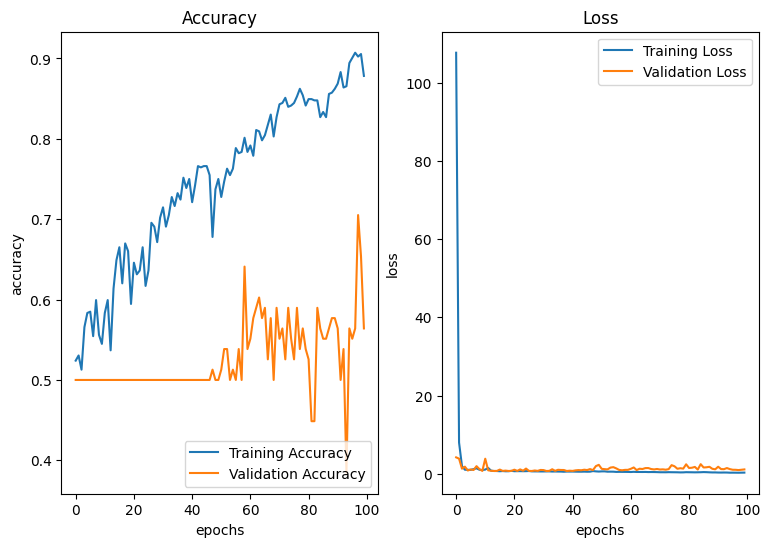

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# ambil statistik pelatihan
acc = history_train_v1.history['accuracy']
val_acc = history_train_v1.history['val_accuracy']
loss= history_train_v1.history['loss']
val_loss= history_train_v1.history['val_loss']

epochs_range = range(epoch)

# plot hasil akurasi pelatihan
plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.title('Accuracy')

# plot hasil loss pelatihan
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss')
plt.show()
plt.savefig('/content/gdrive/MyDrive/SKRIPSI/Dataset/.jpg')

In [ ]:
#fine tunning
model_v1.trainable = True

# Let's take a look to see how many layers are in the model_v1
print(f'Number of layers in the base model: {len(model_v1.layers)}')

Number of layers in the base model: 100


In [ ]:
# Fine-tune from this layer onwards
fine_tuning = 100

# Freeze all the layers before fine_tuned_ind
for layer in model_v1.layers[:fine_tuning]:
    layer.trainable =  False

In [ ]:
# Load best weights
# model.load_weights(weight_path)

# Finer learning rate now
opt = keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08)

# Compilation
model_v1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_v1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 111, 111, 32)      896       
                                                                 
 batch_normalization_54 (Ba  (None, 111, 111, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_54 (Activation)  (None, 111, 111, 32)      0         
                                                                 
 dropout_28 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 depthwise_conv2d_26 (Depth  (None, 111, 111, 32)      320       
 wiseConv2D)                                               

In [ ]:
fine_tuned_epochs = 100
total_epochs = epoch + fine_tuned_epochs

history_fined = model_v1.fit_generator(train_generator,
                    steps_per_epoch= train_generator.n/train_generator.batch_size,
                    epochs=epoch,
                    validation_data=validation_generator,
                    validation_steps= validation_generator.n/validation_generator.batch_size,
                    callbacks=[model_check_point_v1])

<ipython-input-17-c96b7cc0730d>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fined = model_v1.fit_generator(train_generator,


Epoch 1/100
14/13 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8558
Epoch 1: val_loss did not improve from 0.69478
13/13 [==============================] - 20s 1s/step - loss: 0.3726 - accuracy: 0.8558 - val_loss: 1.1483 - val_accuracy: 0.5000
Epoch 2/100
14/13 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8670
Epoch 2: val_loss did not improve from 0.69478
13/13 [==============================] - 13s 946ms/step - loss: 0.3500 - accuracy: 0.8670 - val_loss: 1.1166 - val_accuracy: 0.5128
Epoch 3/100
14/13 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.8702
Epoch 3: val_loss did not improve from 0.69478
13/13 [==============================] - 13s 924ms/step - loss: 0.3503 - accuracy: 0.8702 - val_loss: 1.1368 - val_accuracy: 0.5000
Epoch 4/100
14/13 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8365
Epoch 4: val_loss did not improve from 0.69478
13/13 [==============================] 

In [ ]:
def plot_history_fined(history, history_fined, initial_epochs=epoch, loss_max=1):
    """
    Check loss and accuracy evolution after fine tuning
    """

    acc = history.history['accuracy'][:epoch]
    acc += history_fined.history['accuracy']
    val_acc = history.history['val_accuracy'][:epoch]
    val_acc += history_fined.history['val_accuracy']

    loss = history.history['loss'][:epoch]
    loss += history_fined.history['loss']
    val_loss = history.history['val_loss'][:epoch]
    val_loss += history_fined.history['val_loss']


    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 6))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='fine-tuning', ls='--')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy',
            ylim=([0.4,1.005]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.plot([initial_epochs-1,initial_epochs-1],
             [0,1] , label='fine-tuning', ls='--')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

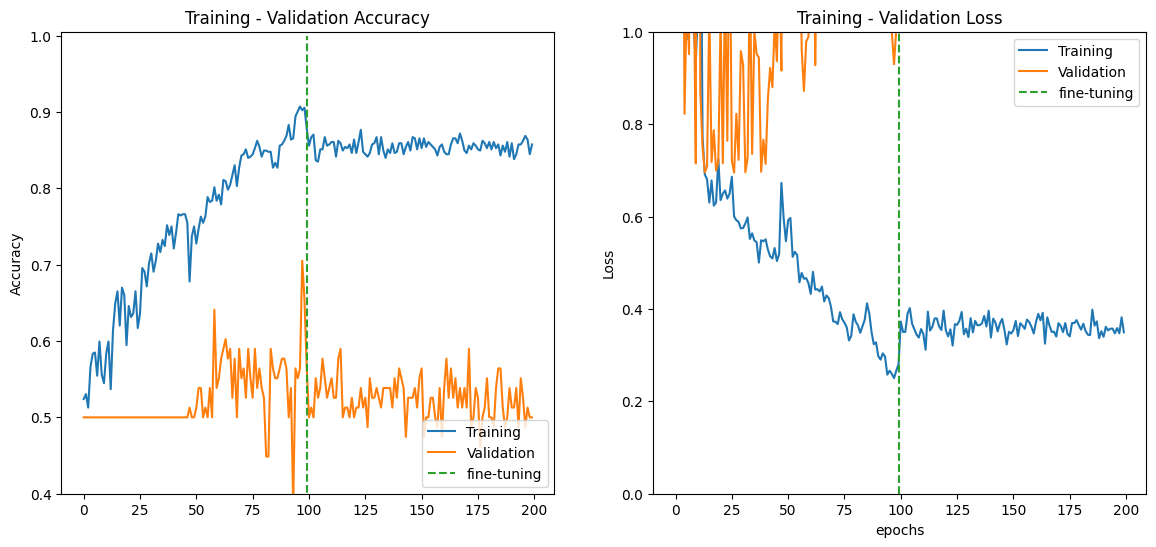

In [ ]:
plot_history_fined(history=history_train_v1, history_fined=history_fined)

1/1 [==============================] - 2s 665ms/step
[[22 17]
 [23 16]]
              precision    recall  f1-score   support

        Solo       0.49      0.56      0.52        39
  Yogyakarta       0.48      0.41      0.44        39

    accuracy                           0.49        78
   macro avg       0.49      0.49      0.48        78
weighted avg       0.49      0.49      0.48        78



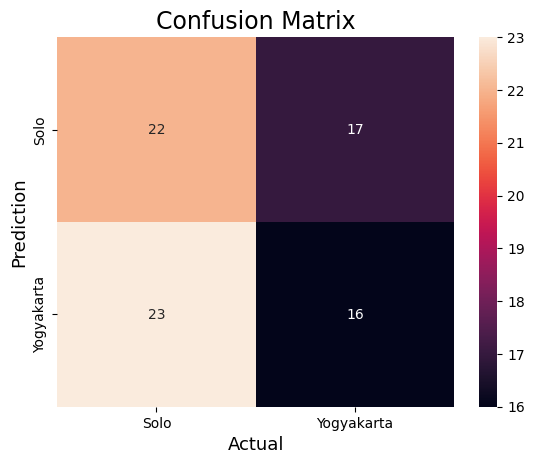

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

step_size_test = validation_generator.n/validation_generator.batch_size
y_pred = mb_v1.predict(validation_generator,steps=step_size_test)
y_pred = np.argmax(y_pred,axis=1)
y_true = validation_generator.classes
target_names = ['Solo','Yogyakarta']
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred,target_names=target_names))
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Solo','Yogyakarta'],
            yticklabels=['Solo','Yogyakarta'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

1/1 [==============================] - 0s 120ms/step


array([[0.6838891, 0.3161109]], dtype=float32)

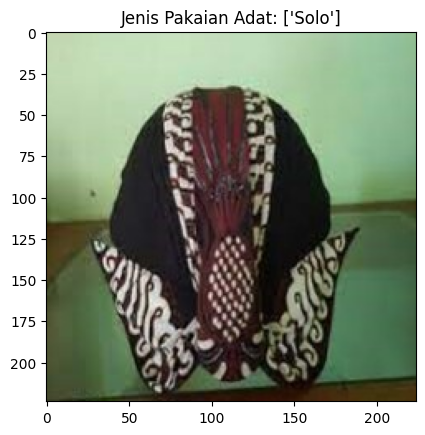

In [ ]:
from keras.preprocessing import image
img = image.load_img('/content/gdrive/MyDrive/SKRIPSI/Dataset/Validasi/Yogyakarta/Aksesoris/4.jpg',target_size=(target_sz,target_sz))
x = image.img_to_array(img)/255.

x = x.reshape((-1,target_sz,target_sz,3))

pred = mb_v1.predict(x)

predicted_class_index = np.argmax(pred,axis=1)

labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in predicted_class_index]

plt.figure()
plt.imshow(img)
plt.title('Jenis Pakaian Adat: '+str(prediction))
pred